# BackPropagation using Auto-Differentiation

In [1]:
import numpy as np
from dataset import *
from mat import *
from copy import deepcopy
import matplotlib.pyplot as plt

# Tanh

In [2]:
class Tanh(MatOperation):
    '''
     af = Tanh()

     Creates a MatOperation object that represents the hyperbolic tangent
     function.

     Usage:
      > af = Tanh()
      > y = af(x)  # where x is a Mat object
    '''
    def __call__(self, x: Mat) -> Mat:
        self.args = [x]
        #===================
        # YOUR CODE HERE
        v = Mat(np.tanh(self.args[0].val))  # replace this line
        
        v.creator = self
        #===================
        return v

    def backward(self, s=1.):
        #===================
        self.args[0].backward(s*(1/np.cosh(self.args[0].val))**2)
        #===================


# Mul

In [3]:
class Mul(MatOperation):
    '''
     af = Mul()

     Creates a MatOperation object that represents the matrix-matrix
     product.

     Usage:
      > af = Mul()
      > y = af(A, B)  # where A and B are both Mat objects
    '''
    def __call__(self, a: Mat, b: Mat) -> Mat:
        self.args = [a,b]
        #===================
        # YOUR CODE HERE
        v = Mat(np.matmul(self.args[0].val, self.args[1].val))  # replace this line
        
        v.creator = self
        #===================
        return v

    def backward(self, s: np.ndarray):
        #===================
        self.args[0].backward(np.matmul(s, np.transpose(self.args[1].val)))
        self.args[1].backward(np.matmul(np.transpose(self.args[0].val), s))
        
        #===================
        

# CategoricalCE

In [4]:
class CategoricalCE(MatOperation):
    '''
     cce = CategoricalCE()

     Creates a categorical cross-entropy function, with the following specifications:
      loss = cce(y, target)

     where
      y       Mat object with output vectors in rows
      target  Mat object with one-hot target vectors in rows

     Returns the mean categorical cross-entropy as a (1,1) Mat object.
    '''
    def __call__(self, y: Mat, target: Mat) -> Mat:
        self.args = [y]
        #===================
        # YOUR CODE HERE
        self.target = target
        
        log_y = np.log(self.args[0].val)
        l = np.sum(np.multiply(self.target.val, log_y), keepdims=True)
        v = Mat(np.sum(l, keepdims=True) / -len(y))
        
        v.creator = self
        #===================

        return v

    def backward(self, s=1.):
        #===================
        self.args[0].backward(-s*(self.target.val/self.args[0].val)/
                              self.args[0].rows)
        #===================


# Connection

In [5]:
class Connection():
    '''
     lyr = Connection(from_nodes=1, to_nodes=1)

     Creates a layer of all-to-all connections.

     Inputs:
       from_nodes  number of nodes in source layer
       to_nodes    number of nodes in receiving layer
      
     Usage:
       lyr.W       # holds the connection weights (Mat object)
       lyr.b       # holds the biases (Mat object)
       lyr.params  # a list of learnable parameters, [W,b]
       z = lyr(h)  # projects activities h (Mat) through the
                   # connection to get input currents z (Mat)
                   # ie. z = h @ W + b
    '''
    def __init__(self, from_nodes=1, to_nodes=1):
        self.Nin = from_nodes    # number of nodes in input (lower) layer
        self.Nout = to_nodes     # number of nodes in higher layer

        # Random initial connection weights (W) and biases (b).
        self.W = Mat( np.random.randn(self.Nin, self.Nout) / np.sqrt(self.Nin) )
        self.b = Mat( np.zeros(self.Nout) )
        
        # Add W and b to the list of learnable parameters.
        self.params = [self.W, self.b]

    def __call__(self, x):
        self.mul = Mul()
        self.m = self.mul(x, self.W)

        self.plus = Plus()
        reshape_b = Mat(np.tile(self.b.val, (self.m.val.shape[0], 1)))
        self.n = self.plus(self.m, reshape_b)
        
        return self.n
        #===================


# Network

In [6]:
class Network(object):
    '''
     net = Network()

     Creates a Network object, which represents a series of
     layers, and a cost (loss) function.

     Usage:
       net.lyr     # returns a list of Layer objects
       net.add_layer(L)  # appends the Layer L to the network
       y = net(x)  # feeds inputs x through the network
                   # x is a 2D numpy array or a Mat object
                   # returns y (Mat object)
       net.loss    # loss function (MatOperation object)
    '''
    def __init__(self):
        self.lyr = []
        self.loss = None   # the loss function to minimize (MatOperation)
        self.loss_history = []

    def add_layer(self, L):
        self.lyr.append(L)

    def __call__(self, x):
        if type(x) not in (Mat, ):
            x = Mat(x)
        for l in self.lyr:
            x = l(x)
        return x

    def parameters(self):
        '''
         params = net.parameters()
         
         Returns a list of Mat objects of the connection weights and
         biases in the network (from bottom to top).
         Note that only Connection layers have these parameters.
        '''
        params = []
        for l in self.lyr:
            if hasattr(l, 'params') and l.params:  # skips empty lists
                for p in l.params:
                    params.append(p)
        return params
    
    def learn(self, ds, lrate=1., epochs=10):
        '''
         net.learn(ds, lrate=1., epochs=10)

         Runs backprop on the network, training on the data from
         the Dataset object ds.

         Inputs:
           ds       a Dataset object
           lrate    learning rate
           epochs   number of epochs to run
        '''
        x = ds.inputs()
        t = ds.targets()
        for epoch in range(epochs):

            y = self(x)             # forward

            # Evaluate the loss
            loss = self.loss(y, t)
            
            # Reset gradient to zero
            loss.zero_grad()
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update learnable network parameters (weights and biases)
            params = self.parameters()
            for param in params:
                # Update parameter
                param.val -= lrate * param.grad
            
            #===================

            self.loss_history.append(loss.val[0,0])

            # Report progress
            if epoch%50==0:
                print(f'{epoch}: cost = {loss()[0,0]}')
        #return losses
        return self.loss_history

<class 'dataset.MatAnnuli'>


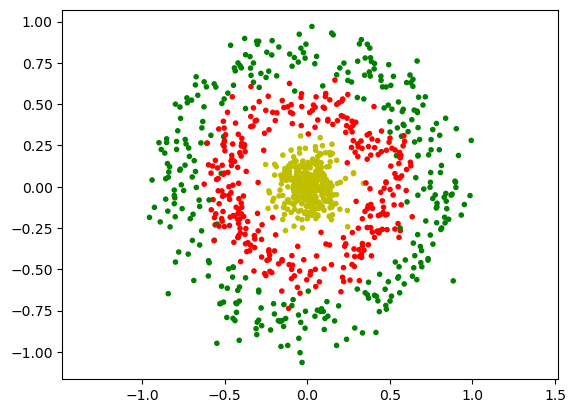

In [7]:
n = 1000 #number of samples
mds = MatAnnuli(n, noise=1.)
print(type(mds))
mds.plot()
# or...
#mds = MatUClasses(n=1000)
#mds.plot()

##  Create a network

In [8]:
# Create a network object
net = Network()

# Add layers using
#  net.add_layer(...)
net.add_layer(Connection(from_nodes=2, to_nodes=15)) 
net.add_layer(ReLU())
net.add_layer(Connection(from_nodes=15, to_nodes=10)) 
net.add_layer(Tanh())
net.add_layer(Connection(from_nodes=10, to_nodes=5)) 
net.add_layer(Tanh())
net.add_layer(Connection(from_nodes=5, to_nodes=3))  
net.add_layer(Softmax())
# Then choose a loss function by setting net.loss

cce = CategoricalCE()
net.loss = cce

## Train the network

0: cost = 1.1803687508901568
50: cost = 0.9930210271362678
100: cost = 0.97325618506976
150: cost = 0.9685335003488388
200: cost = 0.9655136923962935
250: cost = 0.9630774694424151
300: cost = 0.9608582850071529
350: cost = 0.95859443179999
400: cost = 0.9559335161224068
450: cost = 0.9522160194855394
500: cost = 0.9458464299960981
550: cost = 0.9318224090940591
600: cost = 0.892871184060204
650: cost = 0.7860799082515887
700: cost = 0.5958996674031553
750: cost = 0.4008807768197377
800: cost = 0.27486587538327467
850: cost = 0.20979564901777922
900: cost = 0.17356735837779116
950: cost = 0.1510494873055564


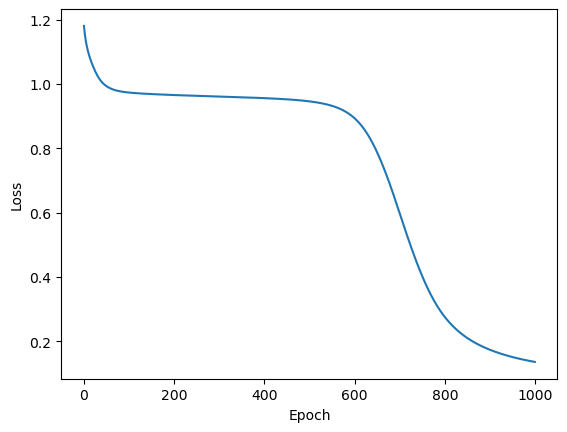

In [9]:
# Call net.learn, and plot the learning curve (loss vs epochs)
net.learn(mds, lrate=0.2, epochs=1000)
plt.plot(net.loss_history); plt.xlabel('Epoch'); plt.ylabel('Loss');

# Plot the points

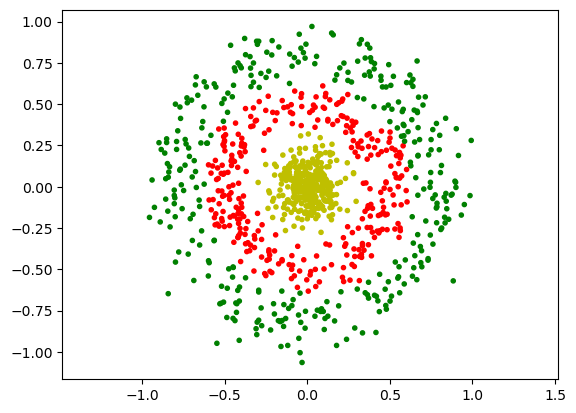

In [10]:
# Plot the dataset using the network's output as labels
# Run the inputs through the network
y = net(mds.inputs())
# and use the outputs as labels.

mds.plot(labels=y);

# Model's training accuracy

In [11]:
# Check how many of the outputs have the largest value
# in the correct category?
y_pred = y.val
y_label = mds.targets().val
count = 0
for i in range(n):
    if np.argmax(y_pred[i]) == np.argmax(y_label[i]):
        count += 1
    accuracy = (count/n) * 100
    
print(f'The model’s accuracy is {round(accuracy, 3)}%')

# Percentage of correct classifications.

The model’s accuracy is 96.1%
